#Emotion Analysis with Hugging Face

bert based distilbert model will be used

OVERSAMPLE UNDERSAMPLE

DENGESİZ VERİLER İÇİN İMBALANCED LEARN

TOKEN METNN EN KÜÇÜK PARÇASI

# adding libraries

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizer
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

# Dataset Loading

In [3]:
emotions = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Understanding the Dataset

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds=emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
len(train_ds)

16000

In [7]:
train_ds[23]

{'text': 'i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me',
 'label': 1}

In [8]:
train_ds.column_names

['text', 'label']

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

# From Dataset to Pandas

In [11]:
emotions.set_format(type="pandas")
df=emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"]=df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Data Visualization

<Figure size 1000x500 with 0 Axes>

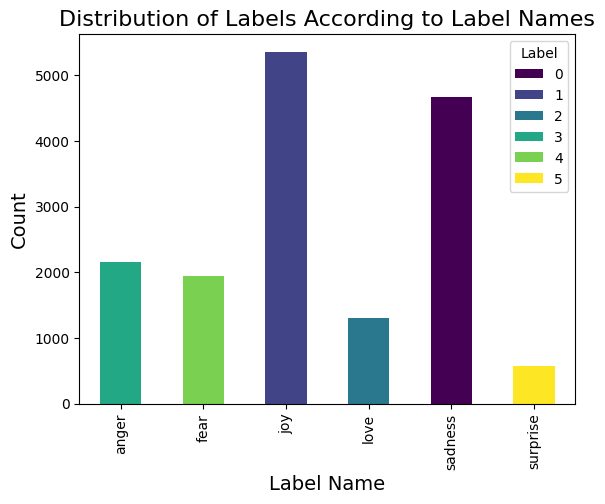

In [13]:
label_counts = df.groupby(['label_name', 'label']).size().unstack()

# Çubuk grafiği oluşturun
plt.figure(figsize=(10,5))
label_counts.plot(kind='bar', stacked=True, colormap='viridis')

# Başlık ve etiketler ekleyin
plt.title("Distribution of Labels According to Label Names", fontsize=16)
plt.xlabel("Label Name", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Lejantı ekleyin
plt.legend(title='Label')

# Grafik göster
plt.show()


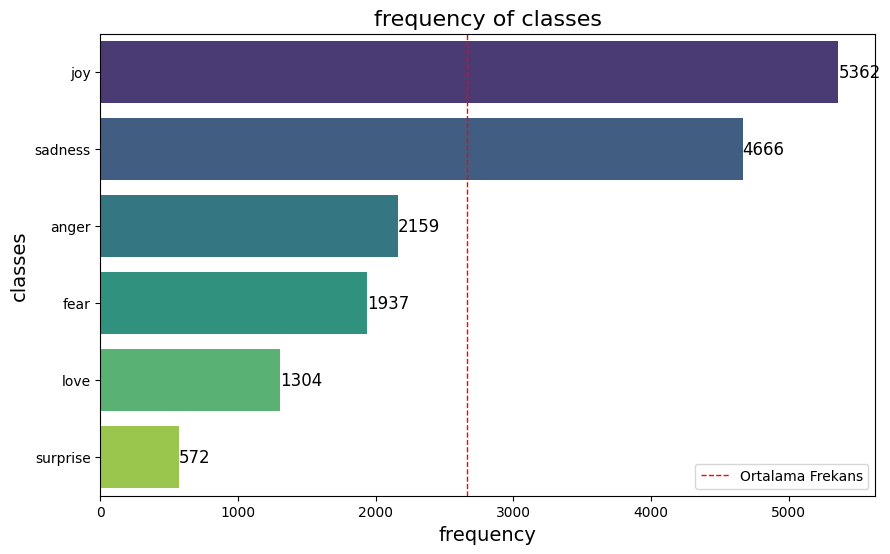

In [14]:
colors = sns.color_palette("viridis", len(df["label_name"].unique()))

plt.figure(figsize=(10, 6))
sns.countplot(y="label_name", data=df, palette=colors, order=df["label_name"].value_counts().index)

plt.title("frequency of classes", fontsize=16)
plt.xlabel("frequency", fontsize=14)
plt.ylabel("classes", fontsize=14)

plt.axvline(x=df["label_name"].value_counts().mean(), color='red', linestyle='--', linewidth=1, label='Ortalama Frekans')

for i, v in enumerate(df["label_name"].value_counts()):
    plt.text(v + 0.1, i, str(v), color='black', va='center', fontsize=12)

plt.legend()
plt.show()

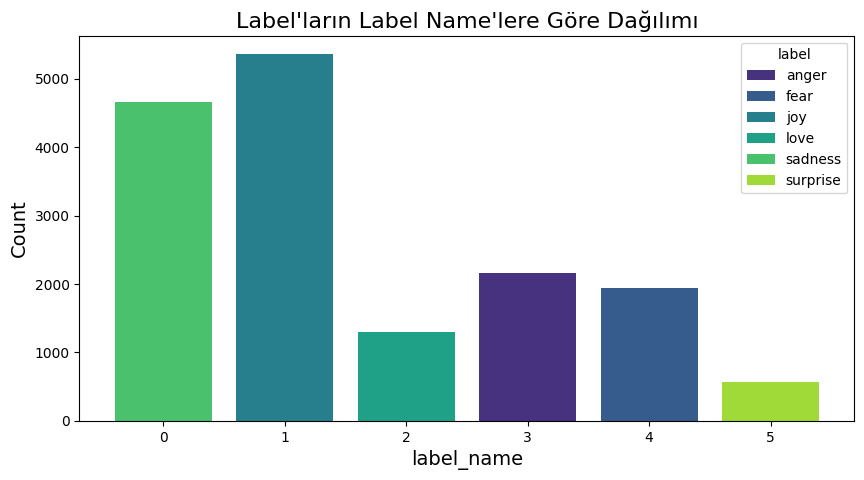

In [15]:
label_counts = df.groupby(['label_name', 'label']).size().unstack()

# Ortak bir renk paleti oluşturun
colors = sns.color_palette("viridis", len(df["label_name"].unique()))

# Çubuk grafiği oluşturun
plt.figure(figsize=(10, 5))
for i, label_name in enumerate(label_counts.index):
    plt.bar(label_counts.columns, label_counts.loc[label_name], color=[colors[i] for _ in label_counts.columns], label=label_name)

# Başlık ve etiketler ekleyin
plt.title("Label'ların Label Name'lere Göre Dağılımı", fontsize=16)
plt.xlabel("label_name", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Lejantı ekleyin
plt.legend(title='label', loc='upper right')

# Grafik göster
plt.show()

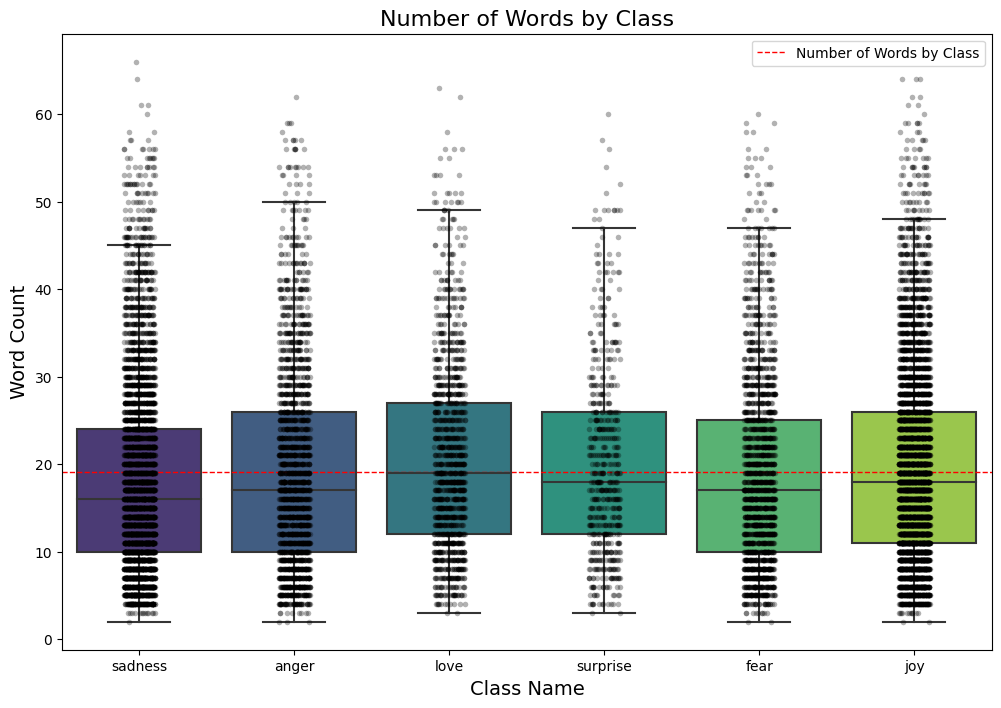

In [16]:
df["words_per_tweet"] = df["text"].str.split().apply(len)

plt.figure(figsize=(12, 8))
sns.boxplot(x="label_name", y="words_per_tweet", data=df, showfliers=False, palette="viridis")
sns.stripplot(x="label_name", y="words_per_tweet", data=df, color="black", size=4, alpha=0.3)

plt.title("Number of Words by Class", fontsize=16)
plt.xlabel("Class Name", fontsize=14)
plt.ylabel("Word Count", fontsize=14)

plt.axhline(y=df["words_per_tweet"].mean(), color='red', linestyle='--', linewidth=1, label='Number of Words by Class')


plt.legend()
plt.show()


In [17]:
emotions.reset_format()

# Data Preprocessing
making the data fit the modle


# Character Tokenization
It is the process of dividing the text into small meaningful pieces, that is, "tokens". A token represents the smallest meaningful unit in text. These meaningful units can be words, subwords, characters, or even smaller units.

In [18]:
text = "It is fun to work with NLP using HuggingFace."
tokenized_text = list(text)
print(tokenized_text)

['I', 't', ' ', 'i', 's', ' ', 'f', 'u', 'n', ' ', 't', 'o', ' ', 'w', 'o', 'r', 'k', ' ', 'w', 'i', 't', 'h', ' ', 'N', 'L', 'P', ' ', 'u', 's', 'i', 'n', 'g', ' ', 'H', 'u', 'g', 'g', 'i', 'n', 'g', 'F', 'a', 'c', 'e', '.']


In [19]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
# each character was set with a number
print(token2idx)

{' ': 0, '.': 1, 'F': 2, 'H': 3, 'I': 4, 'L': 5, 'N': 6, 'P': 7, 'a': 8, 'c': 9, 'e': 10, 'f': 11, 'g': 12, 'h': 13, 'i': 14, 'k': 15, 'n': 16, 'o': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'w': 22}


In [20]:
input_ids=[token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 20, 0, 14, 19, 0, 11, 21, 16, 0, 20, 17, 0, 22, 17, 18, 15, 0, 22, 14, 20, 13, 0, 6, 5, 7, 0, 21, 19, 14, 16, 12, 0, 3, 21, 12, 12, 14, 16, 12, 2, 8, 9, 10, 1]


In [21]:
df=pd.DataFrame({"name":[]})

# One-hot encoding with Torch

In [22]:
# convert data to tensor
input_ids=torch.tensor(input_ids)

In [23]:
one_hot_encodings=F.one_hot(input_ids,num_classes=len(token2idx))

In [24]:
one_hot_encodings.shape

torch.Size([45, 23])

In [25]:
print(f"Token:{tokenized_text[0]}")

Token:I


In [26]:
print(f"tensor index:",{input_ids[0]})

tensor index: {tensor(4)}


In [27]:
print(f"one hot : {one_hot_encodings[0]}")

one hot : tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [28]:
tokenized_text=text.split()
print(tokenized_text)

['It', 'is', 'fun', 'to', 'work', 'with', 'NLP', 'using', 'HuggingFace.']


# Word Tokenization

Word tokenization is a process that breaks down a text at the word level, isolating each word (or “token”) in the text. This breaks the text into words, using a set of grammatical rules to define words using spaces, punctuation, and other specific characters.

In [29]:
tokenized_text=text.split()
print(tokenized_text)

['It', 'is', 'fun', 'to', 'work', 'with', 'NLP', 'using', 'HuggingFace.']


# Subword Tokenization


In [30]:
model_ckpt="distilbert-base-uncased"
#It is trained using a learning method called "DistilBERT" and is a "base" dimensional model.
#"uncased" indicates that the model was trained in a case-insensitive manner, meaning it does not distinguish between uppercase and lowercase letters.

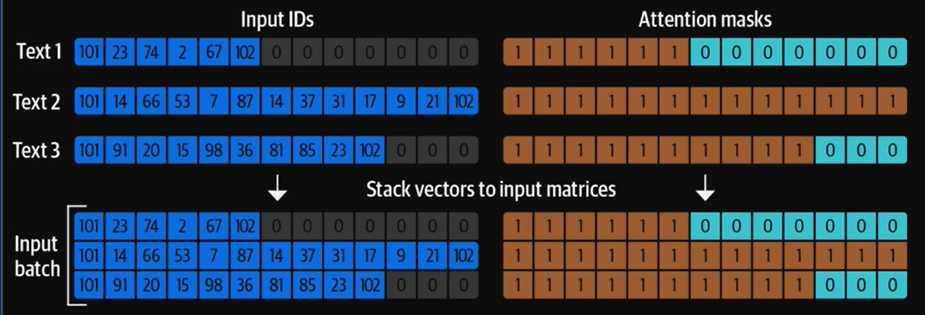

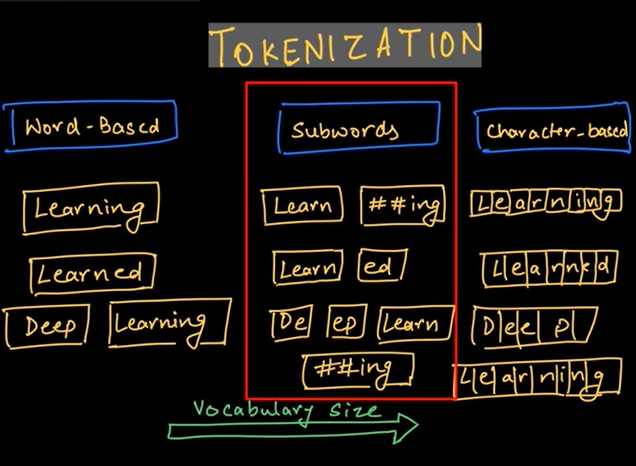

In [31]:
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)
#Creates a tokenizer for a pre-trained language model using Hugging Face's AutoTokenizer class.
#The from_pretrained function takes a parameter containing the name or path of a pretrained model

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [32]:
distilberd_tokenizer=DistilBertTokenizer.from_pretrained(model_ckpt)
#It creates the DistilBERT tokenizer specifically for the DistilBERT model.
#Again, the from_pretrained function takes a parameter containing the name or path of a pretrained DistilBERT model.

In [33]:
encoded_text=tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2009, 2003, 4569, 2000, 2147, 2007, 17953, 2361, 2478, 17662, 12172, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [34]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'it', 'is', 'fun', 'to', 'work', 'with', 'nl', '##p', 'using', 'hugging', '##face', '.', '[SEP]']


In [35]:
tokenizer.convert_tokens_to_string(tokens)


'[CLS] it is fun to work with nlp using huggingface. [SEP]'

In [36]:
tokenizer.vocab_size

30522

In [37]:
tokenizer.model_max_length

512

In [38]:
def tokenize(batch):
  return tokenizer(batch["text"],truncation=True)

In [39]:
print(tokenize(emotions["train"][:2]))
# attention_mask = which data should the model take into account
# input_ids = displays numeric representations of tokens

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [40]:
emotions_encoded= emotions.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
#It is a data collator class that organizes the data set fed to the model especially during training and brings the samples of the same length to the same size.
#The tokenizer parameter specifies a tokenizer object that converts text data into a numeric format.

In [42]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

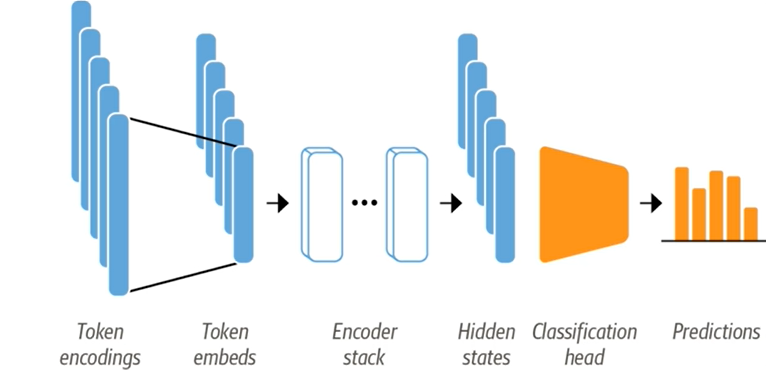

# Model Training

In [44]:
from transformers import AutoModelForSequenceClassification

In [45]:
num_labels = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,
         num_labels = num_labels).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluate

In [46]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [48]:
import evaluate
accuracy = evaluate.load("accuracy")

In [49]:
import numpy as np
def compute_metrics(eval_pred):
  predictions,labels=eval_pred
  predictions=np.argmax(predictions,axis=1)
  return accuracy.compute(predictions=predictions,
                          references=labels)

In [52]:
from huggingface_hub import notebook_login

In [53]:
notebook_login()

In [57]:
from transformers import TrainingArguments

In [66]:
# !pip install transformers[torch] accelerate
!pip install transformers[torch]

In [85]:
# !pip install transformers[torch]
# !pip install accelerate
# # !pip install accelerate==0.20.1
# !pip install --upgrade accelerate
# !pip uninstall accelerate
# !pip install transformers torch
# !pip install accelerate==0.20.1

!pip install transformers --upgrade


# !pip install accelerate -U

In [86]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="distilbert-emotion",
    num_train_epochs = 2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "none"
)

ImportError: ignored

In [87]:
from transformers import Trainer

In [88]:
trainer= Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,

)

NameError: ignored

In [ ]:
trainer.train()

In [ ]:
preds_output=trainer.predict(emotions_encoded["validation"])


In [89]:
preds_output.metrics

NameError: ignored

In [90]:
y_preds=np.argmax(preds_output.predictions,axis=1)

NameError: ignored

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

In [ ]:
def plot_confusion_matrix(y_preds,y_true,labels):
  cm=confusion_matrix(y_true,y_preds,normalize="true")
  fig,ax=plt.subplots(figsize=(6,6))
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
  disp.plot(cmap="Blues",values_format=".2f",ax=ax,
            colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show()



In [91]:
y_valid=np.array(emotions_encoded["validation"["label"]])

labels=emotions["train"].features["label"].names

<>:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
<ipython-input-91-85f346c98e5b>:1: SyntaxWarning: str indices must be integers or slices, not str; perhaps you missed a comma?
  y_valid=np.array(emotions_encoded["validation"["label"]])


TypeError: ignored

In [ ]:
plot_confusion_matrix(y_preds,y_valid,labels)

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

In [92]:
from transformers import pipeline

In [ ]:
model_id=""
classifier=pipeline("text-classification",model=model_id)


In [ ]:
custom-text="I watched a movie "
preds=classifier(custom_text,return_all_scores=True)

preds_df=pd.DataFrame(preds[0])
plt.bar(labels,100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("class probabolity (%)")